In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates: y = a*T + b * X + e

  0%|          | 0/998 [00:00<?, ?it/s]C:\Users\hwb07\AppData\Local\Temp/ipykernel_23964/2096275410.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = data
100%|██████████| 998/998 [00:00<00:00, 3466.07it/s]


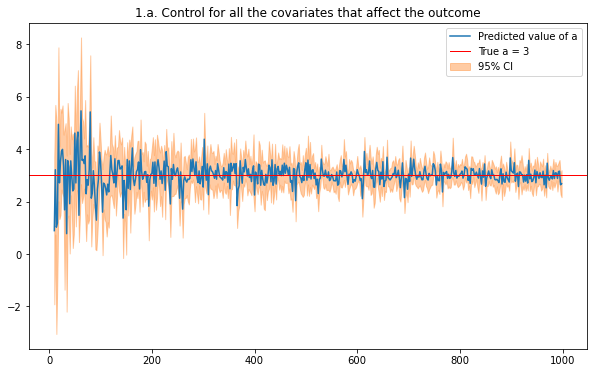

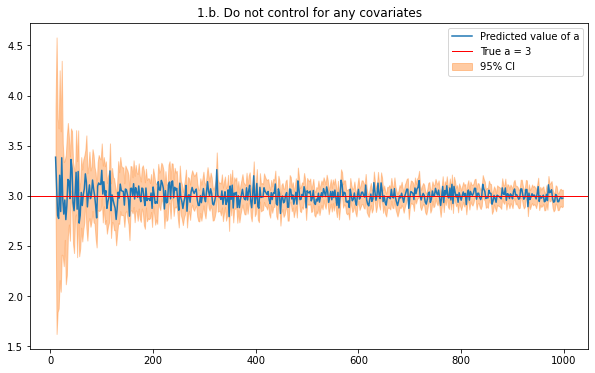

In [2]:
"""
Simulate a DGP
"""
p_n = 5             #number of covariates used
a = 3               #coefficient of the treatment effect
p = 0.5             #probability of being randomly selected
n_values = []
a_hats_1 = []       #case a: do not control for any covariates 
a_hats_se_1 = []
lb_1 = []
ub_1 = []
a_hats_2 = []       #case b: control for all the covariates that affect the outcome
a_hats_se_2 = []
lb_2 = []
ub_2 = []

Nrange = range(10, 1000, 2)
for n in tqdm(Nrange):
        n_values = n_values + [n]

        ##DGP
        treated = random.sample(range(n), round(n*p))            #randomize treatment
        T = np.array([(1 if i in treated else 0) for i in range(n)]).reshape([n,1])
        X = []
        for i in range(p_n):
            X.append(np.reshape(np.random.normal(0,1,n),(n,-1))) #picked 0 and 1 for mean and varriance just for convenience
        X = np.concatenate(X,axis=1)
        b = np.random.normal(1,1,[p_n,1])                        #picked 1 and 1 for mean and varriance just for convenience
        err = np.random.normal(0,1,[n,1])
        Y = a*T + X@b + err
        
        ##case a: do not control for any covariates
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        nt = len(Yt)
        nc = len(Yc)
        a_hat_1 = np.mean(Yt)-np.mean(Yc)
        a_hat_se_1 = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
        a_hats_1 = a_hats_1 + [a_hat_1]
        a_hats_se_1 = a_hats_se_1 + [a_hat_se_1]
        lb_1 = lb_1 + [a_hat_1 - 1.96 * a_hat_se_1]
        ub_1 = ub_1 + [a_hat_1 + 1.96 * a_hat_se_1]
        
        ##case b: control for all the covariates that affect the outcome
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_2 = res.params[0]
        a_hat_se_2 = res.HC1_se[0]
        a_hats_2 = a_hats_2 + [a_hat_2]
        a_hats_se_2 = a_hats_se_2 + [a_hat_se_2]
        lb_2 = lb_2 + [a_hat_2 - 1.96 * a_hat_se_2]
        ub_2 = ub_2 + [a_hat_2 + 1.96 * a_hat_se_2]

##export data to csv
data = []
df = pd.DataFrame(data)
df.index = ['Y','T','X']
for i in tqdm(range(n)):
    data = [[Y[i]], [T[i]], [X[i]]]
    df[i] = data
df.to_csv("simulated_data_1.csv")

##graphs for comparison
caption = """1.a. Control for all the covariates that affect the outcome"""
fig = plt.figure(figsize = (10,6))
plt.plot(n_values,a_hats_1, label='Predicted value of a')
plt.axhline(y=a, color='r', linestyle='-',linewidth=1,label='True a = 3')
plt.title('{}'.format(caption))
plt.fill_between(n_values, lb_1, ub_1,alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
plt.legend()

caption = """1.b. Do not control for any covariates"""
fig = plt.figure(figsize = (10,6))
plt.plot(n_values,a_hats_2, label='Predicted value of a')
plt.axhline(y=a, color='r', linestyle='-',linewidth=1,label='True a = 3')
plt.title('{}'.format(caption))
plt.fill_between(n_values, lb_2, ub_2,alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
plt.legend()

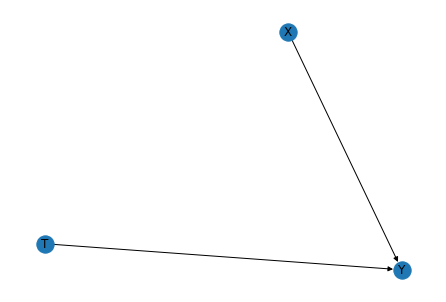

In [3]:
"""
DAG
"""
graph = nx.DiGraph()
graph.add_edge('T','Y')
graph.add_edge('X','Y')
nx.draw(graph, with_labels = True)

In [4]:
"""
Monte Carlo experiment
"""
MC_a = {}
MC_b = {}
R = 2000

##Monte Carlo iterations
for N in [100,1000]:
    a_hats_1 = []
    a_hats_se_1 = []
    a_hats_2 = []
    a_hats_se_2 = []
    for r in tqdm(range(R)):
        
        ##DGP
        treated = random.sample(range(n), round(n*p))            #randomize treatment
        T = np.array([(1 if i in treated else 0) for i in range(n)]).reshape([n,1])
        X = []
        for i in range(p_n):
            X.append(np.reshape(np.random.normal(0,1,n),(n,-1))) #picked 0 and 1 for mean and varriance just for convenience
        X = np.concatenate(X,axis=1)
        b = np.random.normal(1,1,[p_n,1])                        #picked 1 and 1 for mean and varriance just for convenience
        err = np.random.normal(0,1,[n,1])
        Y = a*T + X@b + err
        
        ##case a
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        nt = len(Yt)
        nc = len(Yc)
        a_hat_1 = np.mean(Yt)-np.mean(Yc)
        a_hat_se_1 = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
        a_hats_1 = a_hats_1 + [a_hat_1]
        a_hats_se_1 = a_hats_se_1 + [a_hat_se_1]
        
        ##case b
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_2 = res.params[0]
        a_hat_se_2 = res.HC1_se[0]
        a_hats_2 = a_hats_2 + [a_hat_2]
        a_hats_se_2 = a_hats_se_2 + [a_hat_se_2]
    
    ##record Monte Carlo experiment results
    MC_a[N] = {
        'a_hat_1':np.array(a_hats_1).reshape([len(a_hats_1),1]),
        'a_hat_se_1':np.array(a_hats_se_1).reshape([len(a_hats_se_1),1])
    }
    MC_b[N] = {
        'a_hat_2':np.array(a_hats_2).reshape([len(a_hats_2),1]),
        'a_hat_se_2':np.array(a_hats_se_2).reshape([len(a_hats_se_2),1])    
    }
    
##bias, RMSE and size    
cval = 1.96         ##95% confidence level
a0 = a * np.ones([R,1])

##case a
for N, results in MC_a.items():
    b = results['a_hat_1'] - a0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/results['a_hat_se_1'] # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    print(f'N={N}: bias_a = {bias}, RMSE_a = {rmse}, size_a = {size}')

##case b
print()
for N, results in MC_b.items():
    b = results['a_hat_2'] - a0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/results['a_hat_se_2'] # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    print(f'N={N}: bias_b = {bias}, RMSE_b = {rmse}, size_b = {size}')


100%|██████████| 2000/2000 [00:17<00:00, 116.41it/s]

N=100: bias_a = -0.004422954497324062, RMSE_a = 0.20648155005991725, size_a = 0.043
N=1000: bias_a = 0.0011605389965903155, RMSE_a = 0.20924932676596258, size_a = 0.0565

N=100: bias_b = 0.001169219554055893, RMSE_b = 0.04526131943074371, size_b = 0.05
N=1000: bias_b = -0.0015788501006712141, RMSE_b = 0.04525975255659013, size_b = 0.054


In [5]:
"""
Example
"""

'\nExample\n'

Randomly assign job training sessions to people and see how much their wages increase, some observed covariates include education level, years of working, and so on. 

## 2. Simulate a DGP with a confounder (common cause)

  0%|          | 0/998 [00:00<?, ?it/s]C:\Users\hwb07\AppData\Local\Temp/ipykernel_23964/4277821994.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = data
100%|██████████| 998/998 [00:00<00:00, 2560.78it/s]


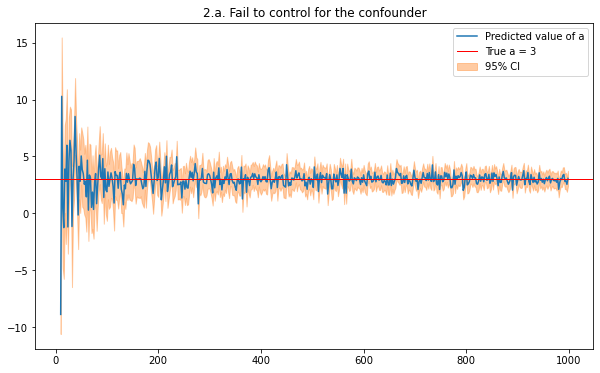

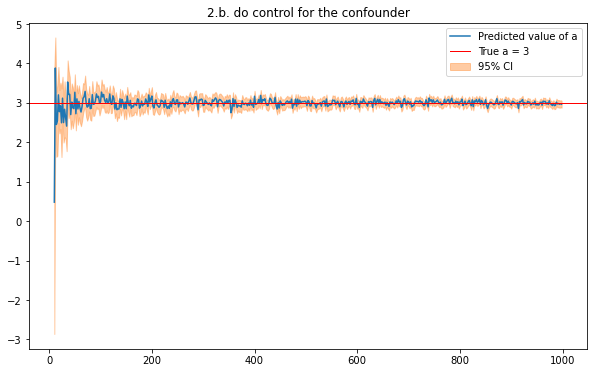

In [6]:
"""
Simulate a DGP
"""
p_n = 5             #number of covariates used
a = 3               #coefficient of the treatment effect
corr = 0.5          # correlation for multivariate normal
n_values = []
a_hats_1 = []       #case a: do not control for any covariates 
a_hats_se_1 = []
lb_1 = []
ub_1 = []
a_hats_2 = []       #case b: control for all the covariates that affect the outcome
a_hats_se_2 = []
lb_2 = []
ub_2 = []

Nrange = range(10, 1000, 2)
for n in tqdm(Nrange):
        n_values = n_values + [n]

        ##DGP
        treated = random.sample(range(n), round(n*p))            #randomize treatment
        T = np.array([(1 if i in treated else 0) for i in range(n)]).reshape([n,1])
        
        X_all = []
        for i in range(p_n+1):                                   #add a confounder
            X_all.append(np.reshape(np.random.normal(0,1,n),(n,-1))) #picked 0 and 1 for mean and varriance just for convenience
        X_all = np.concatenate(X_all,axis=1)
        acc  = []
        for i in range(p_n+1):
            row = np.ones((1,p_n+1)) * corr
            row[0][i] = 1
            acc.append(row)
        cov = np.concatenate(acc,axis=0)
        X_all = np.transpose(np.dot(np.linalg.cholesky(cov),np.transpose(X_all)))
        C = X_all[:,0].reshape([n,1])         #set the first variable as the confounder
        X = X_all[:,1:]
        b = np.random.normal(1,1,[p_n,1])     #picked 1 and 1 for mean and varriance just for convenience
        err = np.random.normal(0,1,[n,1])
        
        Y = a*T + X@b + 10*C + err          #picked 10 just for convenience
        
        ##case a: fail to control for the confounder
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_1 = res.params[0]
        a_hat_se_1 = res.HC1_se[0]
        a_hats_1 = a_hats_1 + [a_hat_1]
        a_hats_se_1 = a_hats_se_1 + [a_hat_se_1]
        lb_1 = lb_1 + [a_hat_1 - 1.96 * a_hat_se_1]
        ub_1 = ub_1 + [a_hat_1 + 1.96 * a_hat_se_1]
        
        ##case b: do control for the confounder
        covars = np.concatenate([T,X,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_2 = res.params[0]
        a_hat_se_2 = res.HC1_se[0]
        a_hats_2 = a_hats_2 + [a_hat_2]
        a_hats_se_2 = a_hats_se_2 + [a_hat_se_2]
        lb_2 = lb_2 + [a_hat_2 - 1.96 * a_hat_se_2]
        ub_2 = ub_2 + [a_hat_2 + 1.96 * a_hat_se_2]

##export data to csv
data = []
df = pd.DataFrame(data)
df.index = ['Y','T','X','C']
for i in tqdm(range(n)):
    data = [[Y[i]], [T[i]], [X[i]], [C[i]]]
    df[i] = data
df.to_csv("simulated_data_2.csv")

##graphs for comparison
caption = """2.a. Fail to control for the confounder"""
fig = plt.figure(figsize = (10,6))
plt.plot(n_values,a_hats_1, label='Predicted value of a')
plt.axhline(y=a, color='r', linestyle='-',linewidth=1,label='True a = 3')
plt.title('{}'.format(caption))
plt.fill_between(n_values, lb_1, ub_1,alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
plt.legend()

caption = """2.b. do control for the confounder"""
fig = plt.figure(figsize = (10,6))
plt.plot(n_values,a_hats_2, label='Predicted value of a')
plt.axhline(y=a, color='r', linestyle='-',linewidth=1,label='True a = 3')
plt.title('{}'.format(caption))
plt.fill_between(n_values, lb_2, ub_2,alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
plt.legend()

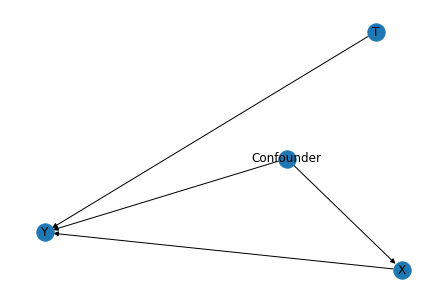

In [7]:
"""
DAG
"""
graph = nx.DiGraph()
graph.add_edge('T','Y')
graph.add_edge('X','Y')
graph.add_edge('Confounder','X')
graph.add_edge('Confounder','Y')
nx.draw(graph, with_labels = True)

In [ ]:
"""
Monte Carlo experiment
"""
MC_a = {}
MC_b = {}
R = 2000

##Monte Carlo iterations
for N in [100,1000]:
    a_hats_1 = []
    a_hats_se_1 = []
    a_hats_2 = []
    a_hats_se_2 = []
    for r in tqdm(range(R)):
        
        ##DGP
        treated = random.sample(range(n), round(n*p))            #randomize treatment
        T = np.array([(1 if i in treated else 0) for i in range(n)]).reshape([n,1])
        
        X_all = []
        for i in range(p_n+1):                                   #add a confounder
            X_all.append(np.reshape(np.random.normal(0,1,n),(n,-1))) #picked 0 and 1 for mean and varriance just for convenience
        X_all = np.concatenate(X_all,axis=1)
        acc  = []
        for i in range(p_n+1):
            row = np.ones((1,p_n+1)) * corr
            row[0][i] = 1
            acc.append(row)
        cov = np.concatenate(acc,axis=0)
        X_all = np.transpose(np.dot(np.linalg.cholesky(cov),np.transpose(X_all)))
        C = X_all[:,0].reshape([n,1])         #set the first variable as the confounder
        X = X_all[:,1:]
        b = np.random.normal(1,1,[p_n,1])     #picked 1 and 1 for mean and varriance just for convenience
        err = np.random.normal(0,1,[n,1])
        
        Y = a*T + X@b + 10*C + err          #picked 10 just for convenience
        
        ##case a: fail to control for the confounder
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_1 = res.params[0]
        a_hat_se_1 = res.HC1_se[0]
        a_hats_1 = a_hats_1 + [a_hat_1]
        a_hats_se_1 = a_hats_se_1 + [a_hat_se_1]
    
        ##case b: do control for the confounder
        covars = np.concatenate([T,X,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_2 = res.params[0]
        a_hat_se_2 = res.HC1_se[0]
        a_hats_2 = a_hats_2 + [a_hat_2]
        a_hats_se_2 = a_hats_se_2 + [a_hat_se_2]
    
    ##record Monte Carlo experiment results
    MC_a[N] = {
        'a_hat_1':np.array(a_hats_1).reshape([len(a_hats_1),1]),
        'a_hat_se_1':np.array(a_hats_se_1).reshape([len(a_hats_se_1),1])
    }
    MC_b[N] = {
        'a_hat_2':np.array(a_hats_2).reshape([len(a_hats_2),1]),
        'a_hat_se_2':np.array(a_hats_se_2).reshape([len(a_hats_se_2),1])    
    }
    
##bias, RMSE and size    
cval = 1.96         ##95% confidence level
a0 = a * np.ones([R,1])

##case a
for N, results in MC_a.items():
    b = results['a_hat_1'] - a0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/results['a_hat_se_1'] # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    print(f'N={N}: bias_a = {bias}, RMSE_a = {rmse}, size_a = {size}')

##case b
print()
for N, results in MC_b.items():
    b = results['a_hat_2'] - a0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/results['a_hat_se_2'] # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    print(f'N={N}: bias_b = {bias}, RMSE_b = {rmse}, size_b = {size}')


 57%|█████▋    | 1148/2000 [00:11<00:08, 102.77it/s]

In [ ]:
"""
Example
"""

If we use how much exercise a person do (x) to evaluate his/her chance of getting sick (Y), age is the common cause confounder (C) as age affects both x and Y. 

## 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

In [ ]:
"""
Simulate a DGP
"""
a = 3  
b = 2
n_values = []
a_hats_1 = []       #case a: do not control for any covariates 
a_hats_se_1 = []
lb_1 = []
ub_1 = []
a_hats_2 = []       #case b: control for all the covariates that affect the outcome
a_hats_se_2 = []
lb_2 = []
ub_2 = []

Nrange = range(10, 1000, 2)
for n in tqdm(Nrange):
        n_values = n_values + [n]

        ##DGP
        treated = random.sample(range(n), round(n*p))            #randomize treatment
        T = np.array([(1 if i in treated else 0) for i in range(n)]).reshape([n,1])
        err_1 = np.random.normal(0,1,[n,1])
        err_2 = np.random.normal(0,1,[n,1])
        X_0 = np.reshape(np.random.normal(0,1,n),(n,-1))
        
        X = a*T + X_0 + err_1  #the variable in between the path from the treatment to the outcome

        Y = b*X + err_2

        ##case a: control for the variable in between the path from cause to effect
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_1 = res.params[0]
        a_hat_se_1 = res.HC1_se[0]
        a_hats_1 = a_hats_1 + [a_hat_1]
        a_hats_se_1 = a_hats_se_1 + [a_hat_se_1]
        lb_1 = lb_1 + [a_hat_1 - 1.96 * a_hat_se_1]
        ub_1 = ub_1 + [a_hat_1 + 1.96 * a_hat_se_1]
        
        ##case b: do not control for the variable in between the path from cause to effect
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_2 = res.params[0]
        a_hat_se_2 = res.HC1_se[0]
        a_hats_2 = a_hats_2 + [a_hat_2]
        a_hats_se_2 = a_hats_se_2 + [a_hat_se_2]
        lb_2 = lb_2 + [a_hat_2 - 1.96 * a_hat_se_2]
        ub_2 = ub_2 + [a_hat_2 + 1.96 * a_hat_se_2]

##export data to csv
data = []
df = pd.DataFrame(data)
df.index = ['Y','T','X']
for i in tqdm(range(n)):
    data = [[Y[i]], [T[i]], [X[i]]]
    df[i] = data
df.to_csv("simulated_data_3.csv")

##graphs for comparison
caption = """3.a. control for the variable in between the path from cause to effect"""
fig = plt.figure(figsize = (10,6))
plt.plot(n_values,a_hats_1, label='Predicted value of a')
plt.axhline(y=a, color='r', linestyle='-',linewidth=1,label='True a = 3')
plt.title('{}'.format(caption))
plt.fill_between(n_values, lb_1, ub_1,alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
plt.legend()

caption = """3.b. do not control for the variable in between the path from cause to effect"""
fig = plt.figure(figsize = (10,6))
plt.plot(n_values,a_hats_2, label='Predicted value of a')
plt.axhline(y=a, color='r', linestyle='-',linewidth=1,label='True a = 3')
plt.title('{}'.format(caption))
plt.fill_between(n_values, lb_2, ub_2,alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
plt.legend()

In [ ]:
"""
DAG
"""
graph = nx.DiGraph()
graph.add_edge('T','X')
graph.add_edge('X','Y')
nx.draw(graph, with_labels = True)

In [ ]:
"""
Monte Carlo experiment
"""
MC_a = {}
MC_b = {}
R = 2000

##Monte Carlo iterations
for N in [100,1000]:
    a_hats_1 = []
    a_hats_se_1 = []
    a_hats_2 = []
    a_hats_se_2 = []
    for r in tqdm(range(R)):
        
        ##DGP
        treated = random.sample(range(n), round(n*p))            #randomize treatment
        T = np.array([(1 if i in treated else 0) for i in range(n)]).reshape([n,1])
        err_1 = np.random.normal(0,1,[n,1])
        err_2 = np.random.normal(0,1,[n,1])
        X_0 = np.reshape(np.random.normal(0,1,n),(n,-1))
        
        X = a*T + X_0 + err_1  #the variable in between the path from the treatment to the outcome

        Y = b*X + err_2
        
        ##case a: control for the variable in between the path from cause to effect
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_1 = res.params[0]
        a_hat_se_1 = res.HC1_se[0]
        a_hats_1 = a_hats_1 + [a_hat_1]
        a_hats_se_1 = a_hats_se_1 + [a_hat_se_1]
    
        ##case b: do not control for the variable in between the path from cause to effect
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        a_hat_2 = res.params[0]
        a_hat_se_2 = res.HC1_se[0]
        a_hats_2 = a_hats_2 + [a_hat_2]
        a_hats_se_2 = a_hats_se_2 + [a_hat_se_2]
    
    ##record Monte Carlo experiment results
    MC_a[N] = {
        'a_hat_1':np.array(a_hats_1).reshape([len(a_hats_1),1]),
        'a_hat_se_1':np.array(a_hats_se_1).reshape([len(a_hats_se_1),1])
    }
    MC_b[N] = {
        'a_hat_2':np.array(a_hats_2).reshape([len(a_hats_2),1]),
        'a_hat_se_2':np.array(a_hats_se_2).reshape([len(a_hats_se_2),1])    
    }
    
##bias, RMSE and size    
cval = 1.96         ##95% confidence level
a0 = a * np.ones([R,1])

##case a
for N, results in MC_a.items():
    b = results['a_hat_1'] - a0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/results['a_hat_se_1'] # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    print(f'N={N}: bias_a = {bias}, RMSE_a = {rmse}, size_a = {size}')

##case b
print()
for N, results in MC_b.items():
    b = results['a_hat_2'] - a0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/results['a_hat_se_2'] # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    print(f'N={N}: bias_b = {bias}, RMSE_b = {rmse}, size_b = {size}')


In [ ]:
"""
Example
"""

Randomly assign new medicines(T) to patients.These new medicines have effect on the health level (X) of them, and their health level have effect against the severeness of disease (Y).